In [1]:
from scipy import signal
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("ticks")
import matplotlib.pyplot as plt
import os; os.getcwd()

'/home/conradin/projects/master_20/dms_Ad_norm/scripts'

In [2]:
def get_specDens(list_of_files, min_period=50, max_period=90, bin_size=1000, step_size=200, ts1_addition=0):
    
    spectral_density = pd.DataFrame(columns=["mid", "specDens", "genotype", "sample"])
    
    # init heatmap dict
    heatmap_dict = {}
    
    for wiggle in list_of_files:

        print("Now processing " + wiggle)

        df = pd.read_csv(
            wiggle,
            sep =" ",
            names = ["pos", "score"],
            skiprows = 1).set_index("pos")

        # remove extreme values from the footprint
        df["zscore"] = (df["score"] - df["score"].mean()) / df["score"].std(ddof=0)
        # get mean value of all values without outliers
        avg = df.loc[abs(df["zscore"]) < 10,]["score"].mean()
        

        # replace every value where zscore is above 10 or below -10 with the average
        df = df.where(abs(df["zscore"]) < 10, avg)


        #### Convert the footprint to array
        score = np.array(df["score"])

        ### Calculate the Periodogram for every bin
        periodogram_df = pd.DataFrame(columns=["freqs", "spectrum", "start", "end"])
        start = 0
        end = bin_size
        while end < len(df):  

            mid = int((start + end) / 2)

            # get the index of wt and ts1 on the same level
            if "ts1" in wiggle:
                #mid += (3171 - (bin_size/2))
                mid += ts1_addition
                genotype = "ts1"
            else:
                genotype = "WT"
                
            if "free" in wiggle:
                treatment = "free"
            else:
                treatment = "virus"

            sequence = score[start:end]
            freqs, spectrum = signal.periodogram(
                sequence,
                window="boxcar",
                nfft=2*34062,
                detrend="linear",
                scaling="density")

            # do the temp df for the periodogram
            temp_df = pd.DataFrame({"freqs":freqs, "spectrum":spectrum})
            temp_df["mid"] = mid
            temp_df["mid"] = temp_df["mid"].astype("int")
            temp_df["start"] = start
            temp_df["end"] = end
            periodogram_df = periodogram_df.append(temp_df)

            # update start and end point
            start += step_size
            end += step_size 

        periodogram_df["mid"] = periodogram_df["mid"].astype("int")
        periodogram_df["periods"] = 1/ periodogram_df["freqs"] # get period from frequency
        periodogram_df["periods"] = periodogram_df["periods"].replace(np.inf, 34062 * 2) # replace inf values
        periodogram_df["periods_int"] = round(periodogram_df["periods"]).astype("int") # round all periods to int
        # the next line calculates the median of all spectra that correspond to 1 period and pivots the table for heatmap
        heatmap_df = periodogram_df.groupby(["periods_int", "mid"]).median().drop(columns=["freqs", "periods"]).reset_index().pivot(index="periods_int", columns="mid", values="spectrum")
        heatmap_df = heatmap_df.reindex(index=heatmap_df.index[::-1]) # flip the index so smaller periods are at the bottom
        
        
        ## periodogram Line
        heatmap_pVII = heatmap_df.loc[heatmap_df.index >= min_period,]
        heatmap_pVII = heatmap_pVII.loc[heatmap_pVII.index <= max_period,]
        
        heatmap_dict[wiggle] = heatmap_pVII

        # add the max of the 50-90 region to the dataframe
        temp_df = pd.DataFrame(columns=["mid", "specDens", "genotype"])
        temp_df["mid"] = heatmap_pVII.sum().index.tolist()
        temp_df["specDens"] = heatmap_pVII.sum().tolist() # add the sum of the periods
        temp_df["genotype"] = genotype
        temp_df["treatment"] = treatment
        temp_df["sample"] = os.path.basename(wiggle)
        spectral_density = spectral_density.append(temp_df)

    return(spectral_density, heatmap_dict)

In [3]:
def average_heatmaps(hm1, hm2):
    index = hm1.index
    cols = hm1.columns
    avg_heatmap = np.mean( np.array([ hm1.to_numpy(), hm2.to_numpy() ]), axis=0)
    avg_heatmap = pd.DataFrame(avg_heatmap).set_index(index)
    avg_heatmap.columns = cols
    
    return(avg_heatmap)

In [3]:
# define all samples
all_samples = {
    "WT":[
        "../raw_footprint/DMS_footprint/AdWT_free_DMS_2_footprint.wig",
        "../raw_footprint/DMS_footprint/AdWT_free_DMS_1_footprint.wig",
        "../raw_footprint/DMS_footprint/AdWT_virus_DMS_2_footprint.wig",
        "../raw_footprint/DMS_footprint/AdWT_virus_DMS_1_footprint.wig"
    ],
    "ts1":[
        "../raw_footprint/DMS_footprint/AdMUT_free_ts1_DMS_2_footprint.wig",
        "../raw_footprint/DMS_footprint/AdMUT_free_ts1_DMS_1_footprint.wig",
        "../raw_footprint/DMS_footprint/AdMUT_virus_ts1_DMS_2_footprint.wig",
        "../raw_footprint/DMS_footprint/AdMUT_virus_ts1_DMS_1_footprint.wig"
    ]
}

In [8]:
# parameters for spectral density calculation
binsize= 700
stepsize = 35
max_period = 150
out_path = "../plots/periodogram/Periodogram_50-150/"

In [6]:
for genotype in all_samples: # loop through the dictionary
    
    samples = all_samples[genotype] # define the sample set list
    
    # calculate spectral density
    spectral_density, heatmap = get_specDens(samples, bin_size=binsize, step_size=stepsize, max_period=max_period)
    
    # save to csv
    spectral_density.to_csv(out_path + "{}_DATA_binsize{}stepsize{}_maxperiod{}_funcsum.csv".format(genotype, binsize, stepsize, max_period), sep="\t")

    for filename in heatmap:
        base_name = os.path.basename(filename).replace(".wig", "")
        heatmap[filename].to_csv(out_path + "{}_DATAHEATMAP_binsize{}stepsize{}.csv".format(base_name, binsize, stepsize), sep="\t")

Now processing ../raw_footprint/DMS_footprint/AdWT_free_DMS_2_footprint.wig
Now processing ../raw_footprint/DMS_footprint/AdWT_free_DMS_1_footprint.wig
Now processing ../raw_footprint/DMS_footprint/AdWT_virus_DMS_2_footprint.wig
Now processing ../raw_footprint/DMS_footprint/AdWT_virus_DMS_1_footprint.wig
Now processing ../raw_footprint/DMS_footprint/AdMUT_free_ts1_DMS_2_footprint.wig
Now processing ../raw_footprint/DMS_footprint/AdMUT_free_ts1_DMS_1_footprint.wig
Now processing ../raw_footprint/DMS_footprint/AdMUT_virus_ts1_DMS_2_footprint.wig
Now processing ../raw_footprint/DMS_footprint/AdMUT_virus_ts1_DMS_1_footprint.wig


In [7]:
for genotype in all_samples:
    
    samples = all_samples[genotype] # define the sample set list
      
    spectral_density = pd.read_csv(out_path + "{}_DATA_binsize700stepsize35_maxperiod150_funcsum.csv".format(genotype), sep="\t", index_col=0)
    
    heatmap = {}
    for sample in samples:
        base_name = os.path.basename(sample).replace(".wig", "")
        heatmap[sample] = pd.read_csv(out_path + "{}_DATAHEATMAP_binsize700stepsize35.csv".format(base_name), sep="\t", index_col = 0)
    
    # set genotype specific plotting parameters
    if genotype == "ts1":
        palette = {"free":"black", "virus":"deepskyblue"}
        max_x = 30800
    else:
        palette = {"free":"black", "virus":"darkmagenta"}
        max_x = 34062
    
    ### plot line plot
    fig, ax = plt.subplots(figsize=(20,5), sharex=False, sharey=False)

    sns.lineplot(
        "mid",
        "specDens",
        hue = "treatment",
        data = spectral_density,
        palette = palette)


    plt.xlim(0,max_x)
    plt.tight_layout()
    for ext in [".svg",".png"]:
        plt.savefig(
            out_path + "{}_LINEPLOT_binsize{}stepsize{}_maxperiod{}_funcsum{}".format(genotype, binsize, stepsize, max_period, ext),
            dpi = 300,
            bbox_inches="tight"
        )
    plt.close()
    
    ### plot heatmaps
    # define whats free and what is virus
    free_samples = [x for x in samples if "free" in x]
    virus_samples = [x for x in samples if "virus" in x]
    
    # average the heatmaps over the samples
    free_hm = average_heatmaps(heatmap[free_samples[0]], heatmap[free_samples[1]])
    virus_hm = average_heatmaps(heatmap[virus_samples[0]], heatmap[virus_samples[1]])
    
    
    fig, ax = plt.subplots(2, 1, figsize=(22,12), sharex=False, sharey=False) # initiate canvas
    ax[0].set_title("FREE Footprint Heatmap | binsize{}".format(binsize))
    sns.heatmap(free_hm.loc[free_hm.index <= 150,], cmap = "coolwarm", ax=ax[0], vmax=40000, yticklabels=True, rasterized=True)
    ax[0].set_ylabel("period")


    ax[1].set_title("VIRUS Footprint Heatmap | binsize{}".format(binsize))
    sns.heatmap(virus_hm.loc[virus_hm.index <= 150,], cmap = "coolwarm", ax=ax[1], vmax =40000, yticklabels=True, rasterized=True)
    ax[1].set_ylabel("period")

    plt.tight_layout()
    for ext in [".svg",".pdf"]:
        plt.savefig("../plots/periodogram/Periodogram_50-150/{}_HEATMAP_binsize{}stepsize{}_maxperiod{}_funcsum{}".format(genotype, binsize, stepsize, max_period, ext),
                   dpi=300, bbox_inches="tight")
    plt.close()

C:\Users\Conradin\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Conradin\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


# Load in heatmap data and redo heatmaps

In [10]:
out_path = "../plots/periodogram/Periodogram_50-150/"

binsize = 700
stepsize = 35
max_period = 150

yticks = ["50"] + 9*[""] + ["60"] + 9*[""] + ["70"] + 9*[""] + ["80"] + 9*[""] + ["90"] + 9*[""] + ["100"] + 9*[""] + ["110"] + 9*[""] + ["120"] + 9*[""] + ["130"] + 9*[""] + ["140"]+ 9*[""] + ["150"]
yticks = yticks[::-1] 

In [7]:
for genotype in all_samples:
    ### plot heatmaps
    # define whats free and what is virus
    samples = all_samples[genotype]
    free_samples = [x for x in samples if "free" in x]
    virus_samples = [x for x in samples if "virus" in x]
    
    heatmap = {}
    for sample in free_samples:
        base_name = os.path.basename(sample).replace(".wig", "")
        heatmap[sample] = pd.read_csv(out_path + "{}_DATAHEATMAP_binsize700stepsize35.csv".format(base_name), sep="\t", index_col=0)
    for sample in virus_samples:
        base_name = os.path.basename(sample).replace(".wig", "")
        heatmap[sample] = pd.read_csv(out_path + "{}_DATAHEATMAP_binsize700stepsize35.csv".format(base_name), sep="\t", index_col=0)

 
    # average the heatmaps over the samples
    free_hm = average_heatmaps(heatmap[free_samples[0]], heatmap[free_samples[1]])
    virus_hm = average_heatmaps(heatmap[virus_samples[0]], heatmap[virus_samples[1]])
    
    
    fig, ax = plt.subplots(2, 1, figsize=(22,12), sharex=False, sharey=False) # initiate canvas
    ax[0].set_title("FREE Footprint Heatmap | binsize{}".format(binsize))
    sns.heatmap(free_hm.loc[free_hm.index <= max_period,], cmap = "coolwarm", ax=ax[0], vmax=40000, yticklabels=True, rasterized=True)
    ax[0].set_yticklabels(yticks)
    ax[0].set_ylabel("period")


    ax[1].set_title("VIRUS Footprint Heatmap | binsize{}".format(binsize))
    sns.heatmap(virus_hm.loc[virus_hm.index <= max_period,], cmap = "coolwarm", ax=ax[1], vmax =40000, yticklabels=True, rasterized=True)
    ax[1].set_yticklabels(yticks)
    ax[1].set_ylabel("period")

    plt.tight_layout()
    for ext in [".svg",".pdf"]:
        plt.savefig("../plots/periodogram/Periodogram_50-150/{}_HEATMAP_binsize{}stepsize{}_maxperiod{}_funcsum{}".format(genotype, binsize, stepsize, max_period, ext),
                   dpi=300, bbox_inches="tight")
    plt.close()

NameError: name 'out_path' is not defined

# all heatmaps in one image

In [11]:
free_samples = [x for x in all_samples["WT"] if "free" in x]
WT_samples = [x for x in all_samples["WT"] if "virus" in x]
ts1_samples = [x for x in all_samples["ts1"] if "virus" in x]

heatmap = {}
for sample in free_samples:
    base_name = os.path.basename(sample).replace(".wig", "")
    heatmap[sample] = pd.read_csv(out_path + "{}_DATAHEATMAP_binsize700stepsize35.csv".format(base_name), sep="\t", index_col=0)
for sample in WT_samples:
    base_name = os.path.basename(sample).replace(".wig", "")
    heatmap[sample] = pd.read_csv(out_path + "{}_DATAHEATMAP_binsize700stepsize35.csv".format(base_name), sep="\t", index_col=0)
for sample in ts1_samples:
    base_name = os.path.basename(sample).replace(".wig", "")
    ts1 = pd.read_csv(out_path + "{}_DATAHEATMAP_binsize700stepsize35.csv".format(base_name), sep="\t", index_col=0)
    # add an empty prefix to the ts1 heatmaps that brings them up to the same length
    empty_prefix = {}
    for i in range(91):
        empty_prefix[i] = [np.NaN]*101
    empty_prefix = pd.DataFrame(empty_prefix).set_index(ts1.index)
    # concat prefix with the heatmap and add to the dictionary
    heatmap[sample] = pd.concat([empty_prefix, ts1], axis=1)

# average the heatmaps over the samples
free_hm = average_heatmaps(heatmap[free_samples[0]], heatmap[free_samples[1]])
WT_hm = average_heatmaps(heatmap[WT_samples[0]], heatmap[WT_samples[1]])
ts1_hm = average_heatmaps(heatmap[ts1_samples[0]], heatmap[ts1_samples[1]])

### Plot ###
# initiate canvas
fig, ax = plt.subplots(3, 1, figsize=(20,20), sharex=False, sharey=False)

# plot free
ax[0].set_title("free")
sns.heatmap(free_hm.loc[free_hm.index <= max_period,], cmap = "coolwarm", ax=ax[0], vmax=40000, yticklabels=True, rasterized=True)
ax[0].set_yticklabels(yticks)
ax[0].set_ylabel("period")
ax[0].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

# plot WT
ax[1].set_title("AdWT")
sns.heatmap(WT_hm.loc[WT_hm.index <= max_period,], cmap = "coolwarm", ax=ax[1], vmax =40000, yticklabels=True, rasterized=True)
ax[1].set_yticklabels(yticks)
ax[1].set_ylabel("period")
ax[1].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

# plot ts1
ax[2].set_title("Adts1")
sns.heatmap(ts1_hm.loc[ts1_hm.index <= max_period,], cmap = "coolwarm", ax=ax[2], vmax =40000, yticklabels=True, rasterized=True)
ax[2].set_yticklabels(yticks)
ax[2].set_ylabel("period")
ax[2].set_xlabel("genome")
ax[2].set_xticks(range(0, 954, 50))
ax[2].set_xticklabels([x*35 for x in range(0, 954, 50)])


plt.tight_layout()

for ext in [".svg",".pdf"]:
    plt.savefig("../plots/periodogram/Periodogram_50-150/ALL_HEATMAP_binsize{}stepsize{}_maxperiod{}_funcsum{}".format(binsize, stepsize, max_period, ext),
               dpi=300, bbox_inches="tight")
plt.close()

# Correlation

In [17]:
flattened_arrays = pd.DataFrame({
    "free":np.array(free_hm.iloc[:,91:]).flatten("K"),
    "AdWT":np.array(WT_hm.iloc[:,91:]).flatten("K"),
    "Adts1":np.array(ts1_hm.iloc[:,91:]).flatten("K")
})

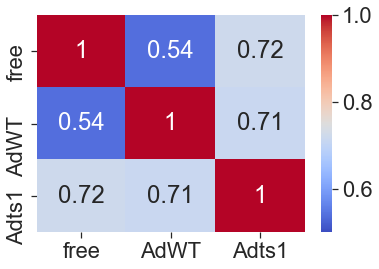

In [19]:
sns.heatmap(flattened_arrays.corr(), cmap="coolwarm", rasterized=True, annot=True, vmin=0.5)

for ext in [".svg",".pdf"]:
    plt.savefig("../plots/periodogram/Periodogram_50-150/ALL_HEATMAP_CORRELATION_binsize{}stepsize{}_maxperiod{}_funcsum{}".format(binsize, stepsize, max_period, ext),
               dpi=300, bbox_inches="tight")